## Dataset

In [ ]:

def find_last_checkpoint(checkpoint_dir):
    epochs = []
    for name in os.listdir(checkpoint_dir):
        if os.path.splitext(name)[-1] == '.pth':
            epochs += [int(name.strip('ckpt_epoch_.pth'))]
    if len(epochs) == 0:
        raise IOError('no checkpoint found in {}'.format(checkpoint_dir))
    return max(epochs)

def save_checkpoint(checkpoint_dir, epoch, model, optimizer=None):
    checkpoint = {}
    checkpoint['epoch'] = epoch

    if isinstance(model, torch.nn.DataParallel):
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    checkpoint['model'] = model_state_dict

    if optimizer is not None:
        optimizer_state_dict = optimizer.state_dict()
        # for k, v in optimizer_state_dict.items():
        #     print(k, type(v))
        # optimizer_state_dict = rename_dict_key(optimizer_state_dict)
        checkpoint['optimizer'] = optimizer_state_dict
    else:
        checkpoint['optimizer'] = None

    torch.save(checkpoint, os.path.join(checkpoint_dir, 'ckpt_epoch_%02d.pth'% epoch))

def load_checkpoint(checkpoint_dir, epoch=-1):
    if epoch == -1:
        epoch = find_last_checkpoint(checkpoint_dir)
    checkpoint_name = 'ckpt_epoch_%02d.pth'% epoch
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    return ckpt

def save_model(checkpoint_dir, epoch, model):
    save_checkpoint(checkpoint_dir, epoch, model, optimizer=None)

def load_model(checkpoint_dir, epoch, model):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        model_state_dict = ckpt['model']

        if isinstance(model, torch.nn.DataParallel):
            model.module.load_state_dict(model_state_dict)
        # elif isinstance(model, torchDDP):
        #     model.module.load_state_dict(model_state_dict)
        # elif isinstance(model, apexDDP):
        #     model.module.load_state_dict(model_state_dict)
        else:
            model.load_state_dict(model_state_dict)
    except Exception as e:
        print('failed to load model, {}'.format(e))
    return model

def load_optimizer(checkpoint_dir, epoch, optimizer):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        optimizer_state_dict = ckpt['optimizer']
        optimizer.load_state_dict(optimizer_state_dict)
    except Exception as e:
        print('failed to load optimizer, {}'.format(e))
    return optimizer

## model

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, in_dim, out_dim, n_position=50):
        super(PositionalEncoding, self).__init__()

        self.linear = torch.nn.Linear(in_features=in_dim, out_features=out_dim) #word embedding
        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, out_dim))

    def _get_sinusoid_encoding_table(self, n_position, out_dim):
        ''' Sinusoid position encoding table '''
        # TODO: make it with torch instead of numpy

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / out_dim) for hid_j in range(out_dim)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        x = self.linear(x)
        return x + self.pos_table[:, :x.size(1)].clone().detach()

class ScaledDotProductAttention(torch.nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, q, k, v, mask=None):
        d_k = q.shape[-1]

        scores = torch.matmul(q / (d_k ** 0.5), k.transpose(2, 3)) #(N, n_head, T, T)
        if mask is not None:
            # print(mask.unsqueeze(0).unsqueeze(0).shape, scores.shape)
            scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0)==0, -1e9)
        scores = torch.nn.Softmax(dim=-1)(scores) #(N, n_head, T, T)
        # print(scores.shape, scores[2, 1, 0, :].sum())
        # print(scores[0, 0])

        output = torch.matmul(scores, v) #(N, n_head, T, out_dim)
        # print(output.shape)
        return output, scores

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, n_head, in_dim, out_dim):
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.out_dim = out_dim

        self.linear_q = torch.nn.Linear(in_features=in_dim, out_features=n_head*out_dim)
        self.linear_k = torch.nn.Linear(in_features=in_dim, out_features=n_head*out_dim)
        self.linear_v = torch.nn.Linear(in_features=in_dim, out_features=n_head*out_dim)

        self.scaled_dot_production_attention = ScaledDotProductAttention()
        self.linear = torch.nn.Linear(in_features=n_head*out_dim, out_features=out_dim)

    def forward(self, q, k, v, mask=None):


        batch_size, len_q, len_kv = q.shape[0], q.shape[1], k.shape[1]

        q = self.linear_q(q).view(batch_size, len_q, self.n_head, self.out_dim) #(N, T, in_dim) --> (N, T, n_head * out_dim) --> (N, T, n_head, out_dim)
        k = self.linear_k(k).view(batch_size, len_kv, self.n_head, self.out_dim)
        v = self.linear_v(v).view(batch_size, len_kv, self.n_head, self.out_dim)


        q = q.transpose(1, 2) #(N, T, n_head, out_dim) --> (N, n_head, T, out_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        # print(q.shape, k.shape, v.shape)

        output, scores = self.scaled_dot_production_attention(q, k, v, mask=mask)

        output = output.transpose(1, 2).contiguous().view(batch_size, len_q, -1)
        # print(output.shape)

        output = self.linear(output) #(N, T, n_head * out_dim) --> (N, T, out_dim)
        # print(output.shape)

        return output, scores

class PositionWiseFeedForward(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(PositionWiseFeedForward, self).__init__()
        self.linear_1 = torch.nn.Linear(in_features=in_dim, out_features=hidden_dim)
        self.linear_2 = torch.nn.Linear(in_features=hidden_dim, out_features=in_dim)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.nn.ReLU()(x)
        x = self.linear_2(x)
        return x

class Encoder(torch.nn.Module):
    def __init__(self, n_head, in_dim, out_dim):
        super(Encoder, self).__init__()

        self.position_enc = PositionalEncoding(in_dim, out_dim)

        self.multi_head_attention_1 = MultiHeadAttention(n_head=n_head, in_dim=out_dim, out_dim=out_dim)
        self.layer_norm_1_1 = torch.nn.LayerNorm(out_dim)

        self.position_wise_feed_forward_1 = PositionWiseFeedForward(out_dim, hidden_dim=128)
        self.layer_norm_1_2 = torch.nn.LayerNorm(out_dim)

        self.scores_for_paint = None

    def forward(self, x):
        qkv = self.position_enc(x) #(N, T, 37) --> (N, T, 64)

        residual = qkv
        outputs, scores = self.multi_head_attention_1(qkv, qkv, qkv)
        self.scores_for_paint = scores.detach().cpu().numpy()
        outputs = self.layer_norm_1_1(outputs + residual) #Add & Norm
        # print(outputs.shape)

        residual = outputs
        outputs = self.position_wise_feed_forward_1(outputs)
        outputs = self.layer_norm_1_2(outputs + residual) #Add & Norm
        # print(outputs.shape)

        return outputs

def get_subsequent_mask(seq):
    seq_len = seq.shape[1]
    ones = torch.ones((seq_len, seq_len), dtype=torch.int, device=seq.device)
    mask = 1 - torch.triu(ones, diagonal=1)
    # print(mask)
    return mask

class Decoder(torch.nn.Module):
    def __init__(self, n_head, in_dim, out_dim):
        super(Decoder, self).__init__()

        self.position_enc = PositionalEncoding(in_dim, out_dim)

        self.multi_head_attention_1_1 = MultiHeadAttention(n_head=n_head, in_dim=out_dim, out_dim=out_dim)
        self.layer_norm_1_1 = torch.nn.LayerNorm(out_dim)

        self.multi_head_attention_1_2 = MultiHeadAttention(n_head=n_head, in_dim=out_dim, out_dim=out_dim)
        self.layer_norm_1_2 = torch.nn.LayerNorm(out_dim)

        self.position_wise_feed_forward_1 = PositionWiseFeedForward(out_dim, hidden_dim=128)
        self.layer_norm_1_3 = torch.nn.LayerNorm(out_dim)

        self.scores_for_paint = None

    def forward(self, enc_outputs, target):
        qkv = self.position_enc(target)

        residual = qkv
        outputs, scores = self.multi_head_attention_1_1(qkv, qkv, qkv, mask=get_subsequent_mask(target))
        outputs = self.layer_norm_1_1(outputs + residual)
        # print(outputs.shape)

        residual = outputs
        outputs, scores = self.multi_head_attention_1_2(outputs, enc_outputs, enc_outputs)
        self.scores_for_paint = scores.detach().cpu().numpy()
        outputs = self.layer_norm_1_2(outputs + residual)

        residual = outputs
        outputs = self.position_wise_feed_forward_1(outputs)
        outputs = self.layer_norm_1_3(outputs + residual)
        # print(outputs.shape)

        return outputs

class Transformer(torch.nn.Module):
    def __init__(self, n_head):
        super(Transformer, self).__init__()

        self.encoder = Encoder(n_head, in_dim=37, out_dim=64)
        self.decoder = Decoder(n_head, in_dim=12, out_dim=64)
        self.linear = torch.nn.Linear(in_features=64, out_features=12)

    def forward(self, x, y):
        enc_outputs = self.encoder(x)
        outputs = self.decoder(enc_outputs, y)
        outputs = self.linear(outputs)
        # print(outputs.shape)
        outputs = torch.nn.Softmax(dim=-1)(outputs)
        # print(outputs.shape)
        return outputs

    def size(self):
        size = sum([p.numel() for p in self.parameters()])
        print('%.2fKB' % (size * 4 / 1024))

if __name__ == '__main__':
    model = Transformer(n_head=4)
    model.size()

    batch_x = torch.randn(16, 10, 37) #(N, T, in_dim)
    batch_y = torch.randn(16, 7, 12) #(N, T, in_dim)
    # print(batch_x.shape)

    pred = model(batch_x, batch_y)
    print(pred.shape)
    print(pred[0][0])

925.55KB
torch.Size([16, 7, 12])
tensor([0.0984, 0.0704, 0.0451, 0.0492, 0.0335, 0.0345, 0.1726, 0.0286, 0.0791,
        0.0732, 0.2643, 0.0512], grad_fn=<SelectBackward0>)


## save_load

In [ ]:

def find_last_checkpoint(checkpoint_dir):
    epochs = []
    for name in os.listdir(checkpoint_dir):
        if os.path.splitext(name)[-1] == '.pth':
            epochs += [int(name.strip('ckpt_epoch_.pth'))]
    if len(epochs) == 0:
        raise IOError('no checkpoint found in {}'.format(checkpoint_dir))
    return max(epochs)

def save_checkpoint(checkpoint_dir, epoch, model, optimizer=None):
    checkpoint = {}
    checkpoint['epoch'] = epoch

    if isinstance(model, torch.nn.DataParallel):
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    checkpoint['model'] = model_state_dict

    if optimizer is not None:
        optimizer_state_dict = optimizer.state_dict()
        # for k, v in optimizer_state_dict.items():
        #     print(k, type(v))
        # optimizer_state_dict = rename_dict_key(optimizer_state_dict)
        checkpoint['optimizer'] = optimizer_state_dict
    else:
        checkpoint['optimizer'] = None

    torch.save(checkpoint, os.path.join(checkpoint_dir, 'ckpt_epoch_%02d.pth'% epoch))

def load_checkpoint(checkpoint_dir, epoch=-1):
    if epoch == -1:
        epoch = find_last_checkpoint(checkpoint_dir)
    checkpoint_name = 'ckpt_epoch_%02d.pth'% epoch
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    return ckpt

def save_model(checkpoint_dir, epoch, model):
    save_checkpoint(checkpoint_dir, epoch, model, optimizer=None)

def load_model(checkpoint_dir, epoch, model):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        model_state_dict = ckpt['model']

        if isinstance(model, torch.nn.DataParallel):
            model.module.load_state_dict(model_state_dict)
        # elif isinstance(model, torchDDP):
        #     model.module.load_state_dict(model_state_dict)
        # elif isinstance(model, apexDDP):
        #     model.module.load_state_dict(model_state_dict)
        else:
            model.load_state_dict(model_state_dict)
    except Exception as e:
        print('failed to load model, {}'.format(e))
    return model

def load_optimizer(checkpoint_dir, epoch, optimizer):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        optimizer_state_dict = ckpt['optimizer']
        optimizer.load_state_dict(optimizer_state_dict)
    except Exception as e:
        print('failed to load optimizer, {}'.format(e))
    return optimizer

In [ ]:
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
from functools import partial
!pip install faker
#from dataset import Dataset, transform, collate_fn
#from model import Transformer
#import save_load as sl

def calc_accuracy(pred, answer):
    # print(pred)
    pred = np.argmax(pred, axis=2)
    answer = np.argmax(answer, axis=2)
    # print(pred.shape, answer.shape)
    correct = (pred == answer).astype(np.int)
    accuracy = correct.sum() / (pred.shape[0] * pred.shape[1])
    # print(accuracy)
    return accuracy

def train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=False):
    pbar = tqdm(total=len(dataloader), bar_format='{l_bar}{r_bar}', dynamic_ncols=True)
    pbar.set_description(f'Epoch %d' % epoch)

    for step, (batch_x, batch_y, _) in enumerate(dataloader):
        if use_gpu:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        pred = model(batch_x, batch_y[:, :-1, :])
        accuracy = calc_accuracy(pred.detach().cpu().numpy(), batch_y[:, 1:, :].detach().cpu().numpy())
        # loss = loss_fn(pred.transpose(1, 2), batch_y)
        loss = loss_fn(pred, batch_y[:, 1:, :])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(**{'loss':loss.detach().cpu().item(), 'accuracy':accuracy})
        pbar.update()
    sl.save_checkpoint('/content/sample_data/checkpoint', epoch, model, optimizer)

    pbar.close()

def main(gpu_id=None):
    dataset = Dataset(transform=transform, n_datas=10000)
    pad_vec = np.zeros(len(dataset.human_vocab))
    pad_vec[dataset.human_vocab['<pad>']] = 1
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=6,
                                            shuffle=True,
                                            num_workers=6,
                                            collate_fn=partial(collate_fn, pad_vec))

    model = Transformer(n_head=2)
    if gpu_id is not None:
        print('use gpu')
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
        n_gpus = torch.cuda.device_count()
        # print('use %d gpu [%s]' % (n_gpus, gpu_id))
        model = model.cuda()
        # model = torch.nn.DataParallel(model, device_ids=[i for i in range(n_gpus)])
    # loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters())

    model = sl.load_model('/content/sample_data/checkpoint', -1, model)
    optimizer = sl.load_optimizer('/content/sample_data/checkpoint', -1, optimizer)

    try:
        trained_epoch = sl.find_last_checkpoint('/content/sample_data/checkpoint')
        print('train form epoch %d' % (trained_epoch + 1))
    except Exception as e:
        print('train from the very begining, {}'.format(e))
        trained_epoch = -1
    for epoch in range(trained_epoch+1, 20):
        train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=True if gpu_id is not None else False)

if __name__ == '__main__':
    if len(sys.argv) == 1:
        main(gpu_id=None)
    else:
        main(gpu_id='0')


100%|██████████| 10000/10000 [00:00<00:00, 26637.76it/s]


use gpu
train form epoch 20



100%|██████████| 10000/10000 [00:00<00:00, 17866.98it/s]


load model 19
[25 apr 2013] --> [2013-04-25<pad><pad><pad><pad>], answer: [['2', '0', '1', '3', '-', '0', '4', '-', '2', '5']]


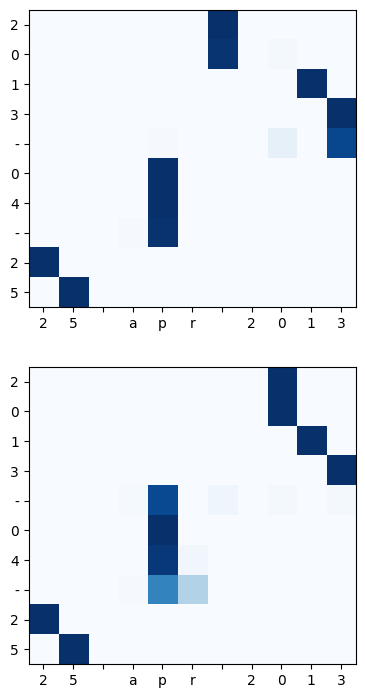

In [ ]:
def translate(model, x, y0):
    x_tensor = torch.from_numpy(x).unsqueeze(0)
    enc_output = model.encoder(x_tensor)
    y0_tensor = torch.from_numpy(y0).unsqueeze(0).unsqueeze(0)
    y_tensor = y0_tensor.clone()

    for step in range(14):
        dec_output = model.decoder(enc_output, y_tensor)
        pred = model.linear(dec_output)
        pred = torch.nn.Softmax(dim=-1)(pred)

        y_tensor = torch.cat((y0_tensor, pred), dim=1)
        # print(y_tensor.shape)
    return y_tensor.squeeze(0)

def paint_score(score, human_readable, pred):
    '''
    score: (n_head, T_dec, T_enc)
    human_readabe: string, length is T_enc
    pred: string, length is T_dec
    '''
    # print(score.shape, len(pred), len(human_readable))
    # print(pred, human_readable)

    n_head = score.shape[0]

    f = plt.figure(figsize=(8, 8.5))
    for i in range(n_head):
        ax = f.add_subplot(n_head, 1, i+1)
        i = ax.imshow(score[i, :10, :], interpolation='nearest', cmap='Blues')

        ax.set_xticks(range(min(30, len(human_readable))))
        ax.set_xticklabels(human_readable[:30], rotation=0)

        #ax.set_xticks(range(30))
        #ax.set_xticklabels(human_readable[:30], rotation=0)

        ax.set_yticks(range(10))
        ax.set_yticklabels(pred[:10], rotation=0)

    plt.savefig('./attention.png')

def main():
    dataset = Dataset(transform=transform, n_datas=10000, seed=None)
    model = Transformer(n_head=2)
    try:
        trained_epoch = sl.find_last_checkpoint('/content/sample_data/checkpoint')
        print('load model %d' % (trained_epoch))
    except Exception as e:
        print('no trained model found, {}'.format(e))
        return
    model = sl.load_model('/content/sample_data/checkpoint', -1, model)
    model.eval()

    x, y, extra = dataset.__getitem__(0)
    # print(x.shape, y.shape)
    # pred = model(torch.from_numpy(x).unsqueeze(0), torch.from_numpy(y).unsqueeze(0)).squeeze()
    pred = translate(model, x, y[0])
    # print(pred.shape)
    pred = np.argmax(pred.detach().numpy(), axis=1)[1:]
    # print(extra['machine_readable'])
    pred = [dataset.inv_machine_vocab[p] for p in pred]
    pred_str = ''.join(pred)
    human_readable = extra['human_readable']
    machine_readable = extra['machine_readable']
    print('[%s] --> [%s], answer: [%s]' % (human_readable, pred_str, list(machine_readable)))

    dec_scores = model.decoder.scores_for_paint
    # print(dec_scores.shape)
    paint_score(dec_scores[0], human_readable, pred)

    # print(len(model.scores_for_paint), model.scores_for_paint[0].shape)
    # scores = np.array(model.scores_for_paint)
    # print(np.argmax(scores, axis=1))

    # f = plt.figure(figsize=(8, 8.5))
    # ax = f.add_subplot(1, 1, 1)
    # i = ax.imshow(scores, interpolation='nearest', cmap='Blues')

    # ax.set_xticks(range(30))
    # ax.set_xticklabels(human_readable[:30], rotation=0)

    # ax.set_yticks(range(10))
    # ax.set_yticklabels(machine_readable[:10], rotation=0)

    # plt.savefig('./attention.png')

if __name__ == '__main__':
    main()